# Group Number:

# Student 1: Ryan Meghoe

# Student 2: Nikita Jain

# Student 3: Andrei Rykov

# Downloading Data and Preliminaries

In [1]:
import pickle
import matplotlib.pyplot as plt
import matplotlib
import numpy as np

from zipfile import ZipFile
import requests
import io

In [2]:
def load_zip(url):
    response = requests.get(url)
    response.raise_for_status()
    zipf = ZipFile(io.BytesIO(response.content))
    return {name: zipf.read(name) for name in zipf.namelist()}

def load_array(zipfile, fn):
    return np.load(io.BytesIO(zipfile[fn]))

In [3]:
"""
This cell loads the training, validation or test data as numpy arrays,
with the positions, initial velocities and charge data of the particles.

The position arrays are shaped as
[simulation id, time point (corresponding to t = 0, 0.5, 1 or 1.5), x/y spatial dimension, particle id].

The initial velocity arrays are shaped as
[simulation id, 1 (corresponding to t=0), x/y spatial dimension, particle id].

The charge arrays are shaped as [simulation id, particle id, 1]

"""

data = load_zip('https://surfdrive.surf.nl/files/index.php/s/OIgda2ZRG8v0eqB/download')

features = ['positions', 'velocities', 'charges']
    
positions_train, velocities_train, charges_train = (load_array(data, f'data/train/{f}.npy') for f in features)
positions_valid, velocities_valid, charges_valid = (load_array(data, f'data/valid/{f}.npy') for f in features)
positions_test, velocities_test, charges_test = (load_array(data, f'data/test/{f}.npy') for f in features)

print('Shapes of the training data:\n')
print(f'positions: {positions_train.shape}')
print(f'velocities: {velocities_train.shape}')
print(f'charges: {charges_train.shape}')

Shapes of the training data:

positions: (10000, 4, 2, 5)
velocities: (10000, 1, 2, 5)
charges: (10000, 5, 1)


In [4]:
print('An example of retrieving data from the arrays:\n\n')

sim_idx = 42
t_idx = 2  # t_idx 0, 1, 2, 3 corresponds to t=0, 0.5, 1 and 1.5 respectively
spatial_idx = (0,1)  # corresponds to both x and y dimension
particle_idx = 3  # corresponds to particle with index 3

p = positions_train[sim_idx, t_idx, spatial_idx, particle_idx]
v = velocities_train[sim_idx, 0, spatial_idx, particle_idx]  # note: this array contains only the inital velocity -> hence the 0
c = charges_train[sim_idx, particle_idx, 0] 

print(
    f'In simulation {sim_idx} of the training set, particle {particle_idx} with charge {c} had coordinates {p}.\nThe initial velocity of this particle was {v}.'
)

An example of retrieving data from the arrays:


In simulation 42 of the training set, particle 3 with charge -1.0 had coordinates [ 2.05159559 -1.46130851].
The initial velocity of this particle was [ 0.28402364 -0.24784824].


In [5]:
print('Overview of no. datapoints:\n')

print(f'{len(positions_train)} train, {len(positions_valid)} validation, {len(positions_test)} test simulations')

Overview of no. datapoints:

10000 train, 2000 validation, 2000 test simulations


In [6]:
def plot_example(pos, vel):

    fig = plt.figure()
    axes = plt.gca()
    axes.set_xlim([-5., 5.])
    axes.set_ylim([-5., 5.])
    colors = ['red', 'blue', 'green', 'orange', 'brown']
    for i in range(pos.shape[-1]):
        plt.plot(pos[0, 0, i], pos[0, 1, i], 'd', color=colors[i])
        plt.plot(pos[-1, 0, i], pos[-1, 1, i], 'x', color=colors[i])
        plt.plot([pos[0, 0, i], pos[0, 0, i] + vel[0, 0, i]], [pos[0, 1, i], pos[0, 1, i] + vel[0, 1, i]], '--', color=colors[i])
    fig.set_size_inches(7, 7)
    plt.xlim(np.min(pos)-1, np.max(pos) +1)
    plt.ylim(np.min(pos)-1, np.max(pos) +1)
    plt.plot([], [], 'd', color='black', label='initial position')
    plt.plot([], [], 'x', color='black', label='final position')
    plt.plot([], [], '--', color='black', label='initial velocity \ndirection and magnitude')
    plt.legend()
    
    plt.show()
    return

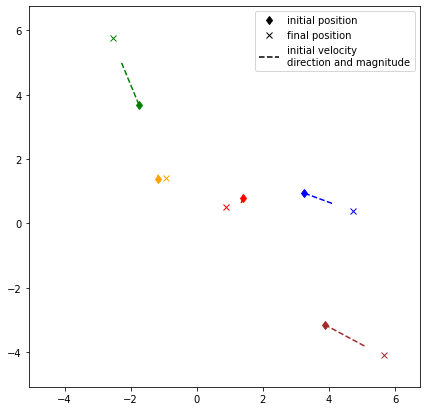

In [7]:
random_idx = np.random.randint(0, 10000)
plot_example(positions_train[random_idx], velocities_train[random_idx])

# Data Handling and Preprocessing

In [8]:
import torch

X_train = torch.cat((torch.tensor(positions_train[:,0,:,:]), torch.tensor(charges_train).squeeze(-1).unsqueeze(1)), dim=1)
X_train = torch.cat((X_train, torch.tensor(velocities_train).squeeze(1)), dim=1) # shape: (simulation id, parameters (x, y, c, v_x, v_y), particle id)
y_train = torch.tensor(positions_train[:,1:,:,:]) # shape: (simulation id, time (0.5, 1, 1.5), (x, y), particle id)

X_valid = torch.cat((torch.tensor(positions_valid[:,0,:,:]), torch.tensor(charges_valid).squeeze(-1).unsqueeze(1)), dim=1)
X_valid = torch.cat((X_valid, torch.tensor(velocities_valid).squeeze(1)), dim=1)
y_valid = torch.tensor(positions_valid[:,1:,:,:])

X_test = torch.cat((torch.tensor(positions_test[:,0,:,:]), torch.tensor(charges_test).squeeze(-1).unsqueeze(1)), dim=1)
X_test = torch.cat((X_test, torch.tensor(velocities_test).squeeze(1)), dim=1)
y_test = torch.tensor(positions_test[:,1:,:,:])

In [9]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)
test_dataset = TensorDataset(X_test, y_test)

In [10]:
batch_size = 64

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Model Implementation

In [41]:
import torch.nn as nn
import torch.nn.functional as F

class ParticleModel(torch.nn.Module):
    def __init__(self, set_size: int = 5, input_size: int = 5, 
                 fau1_out: int = 32, gamma1_out: int = 32, fau2_out: int = 32, gamma2_out: int = 2, device: torch.device = torch.device('cpu')):
        super(ParticleModel, self).__init__()
        # first iteration 
        # layer 1
        # input target (x_t, y_t, c_t, v_t) + neighbour (x_n, y_n, c_n, v_n) + edge (distance(t, n)) 
        # as the result input for first layer is x + x + 1 = 2x + 1 (8 + 1 in our case)
        self.fau_iteration1 = nn.Sequential(nn.Linear(input_size*2 + 1, fau1_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 2
        # input (x_target, y_target, c_target, v_target) + embedding from layer_1 
        self.gamma_iteration1 = nn.Sequential(nn.Linear(fau1_out+input_size, gamma1_out),
                                              nn.LeakyReLU())
        self.embedding_size = (set_size, gamma1_out)

        # second iteration 
        # layer 3
        # input target (embedding from layer 1) + neigbour (embedding from layer 1) + edge (distance(t, n))
        self.fau_iteration2 = nn.Sequential(nn.Linear(gamma1_out*2 + 1, fau2_out),
                                            nn.LeakyReLU())
        # embeddings are calculated

        # layer 4
        # input (x_target, y_target, c_target, v_target) + embedding from layer_3 
        self.gamma_iteration2 = nn.Sequential(nn.Linear(fau2_out + gamma1_out, gamma2_out))
        self.output_size = (set_size, gamma2_out)
        self.device = device

    
    def forward_iteration1(self, particle_set, distances):
        embedding = torch.zeros((particle_set.shape[0], particle_set.shape[1], self.embedding_size[1])).to(self.device)
        
        for i in range(particle_set.shape[1]):
            # concatenate the neighborhood
            x = torch.cat([particle_set[:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[1] - 1, 1)),
                           particle_set[:,list(set(range(particle_set.shape[1])).difference({i}))],
                           distances[:, i, list(set(range(particle_set.shape[1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                   particle_set.shape[1]-1,1))],
                          2)


            x = self.fau_iteration1(x)

            # aggregation function
            # mean as a placeholder for now
            x = x.mean(axis = 1)
            # concatenate 
            x = torch.cat([particle_set[:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)
            embedding[:,i] = self.gamma_iteration1(x).view(embedding[:,i].shape)
        return embedding

    def forward_iteration2(self, particle_set, distances):
        embedding = torch.zeros((particle_set.shape[0], particle_set.shape[1], self.output_size[1])).to(self.device)
        for i in range(particle_set.shape[1]):
            # concatenate the neighborhood
            x = torch.cat([particle_set[:,i].reshape((particle_set.shape[0], 1, -1)).repeat((1, particle_set.shape[1] - 1, 1)),
                           particle_set[:, list(set(range(particle_set.shape[1])).difference({i}))],
                           distances[:, i, list(set(range(particle_set.shape[1])).difference({i}))].reshape((particle_set.shape[0],\
                                                                                                   particle_set.shape[1]-1,1))],
                          2)

            x = self.fau_iteration2(x)

            # aggregation function
            # mean as a placeholder for now
            x = x.mean(axis = 1)

            
            # concatenate 
            x = torch.cat([particle_set[:, i].view(particle_set.shape[0], 1, -1),
                           x.view(particle_set.shape[0], 1, -1)],
                           dim = 2)    

            embedding[:,i] = self.gamma_iteration2(x).view(embedding[:,i].shape)
        return embedding

    def forward(self, particle_set):
        distances = torch.stack([torch.cdist(x_i, x_i) for x_i in particle_set.swapaxes(1,2)], dim=0).to(self.device)
        p1 = self.forward_iteration1(particle_set = particle_set.swapaxes(1,2), distances = distances).to(self.device)
        out = self.forward_iteration2(particle_set=p1, distances=distances)

        return out # (particle_set.shape[0], 5, 2)

# Model Training

In [36]:
# train model

In [63]:
from tqdm import tqdm

class Trainer():
    def __init__(self,
                 model: torch.nn.Module,
                 device: torch.device,
                 criterion: torch.nn.Module,
                 optimizer: torch.optim.Optimizer,
                 training_DataLoader: torch.utils.data.Dataset,
                 validation_DataLoader: torch.utils.data.Dataset ,
                 testing_DataLoader: torch.utils.data.Dataset ,
                 epochs: int
                 ):
        
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.training_DataLoader = training_DataLoader
        self.validation_DataLoader = validation_DataLoader
        self.testing_DataLoader = testing_DataLoader
        self.device = device
        self.epochs = epochs


    def run_trainer(self, target_time):

        epoch_train_losses = []
        epoch_val_losses = []

        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}
        for epoch in tqdm(range(self.epochs)):
                 

            self.model.train()  # train mode

            train_losses=[]
            
            correct = 0
            length = 0
            for x, y in self.training_DataLoader:

                A, B = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                self.optimizer.zero_grad()  # zerograd the parameters

                loss = 0
                out = self.model(A)  # one forward pass
                loss += self.criterion(out.permute(0, 2, 1), B[:,time_to_ind[target_time],:,:])/A.shape[0]   # calculate loss
                
                loss_value = loss.item()
                train_losses.append(loss_value)
                 
                loss.backward()  # one backward pass
                self.optimizer.step()  # update the parameters
            
            epoch_train_losses.append(np.mean(train_losses))
            self.model.eval()  # evaluation mode
            valid_losses = []  # accumulate the losses here

            correct = 0
            length = 0
            for x,  y in self.validation_DataLoader:

                A,B = x.float().to(self.device), y.float().to(self.device) # send to device (GPU or CPU)

                with torch.no_grad():
                    loss = 0
                    
                    out = self.model(A)  # one forward pass
                    loss += self.criterion(out.permute(0, 2, 1), B[:,time_to_ind[target_time],:,:])/A.shape[0]  # calculate loss
                 
                    loss_value = loss.item()
                    valid_losses.append(loss_value)

            epoch_val_losses.append(np.mean(valid_losses))
                
            # print the results
            print(
                f'EPOCH: {epoch+1:0>{len(str(self.epochs))}}/{self.epochs}',
                end=' '
            )
            print(f'LOSS: {np.mean(train_losses):.4f}',end=' ')
            print(f'VAL-LOSS: {np.mean(valid_losses):.4f}',end='\n')

        return epoch_train_losses, epoch_val_losses
        
    def evaluate(self, target_time):

        

        self.model.eval()
        times = [0.5, 1, 1.5]
        time_to_ind = {0.5:0, 1:1, 1.5:2}

        with torch.no_grad():
            loss = 0
            length = 0
            for x,y in self.testing_DataLoader:
                
                A, B = x.float().to(self.device), y.float().to(self.device)
                out = self.model(A)
                # out - (simulation, particle, coord)
                # B -  (simulation id, time (0.5, 1, 1.5), (x, y), particle id)
                #loss += (out - B[:,time_to_ind[target_time],:,:].swapaxes(1,2)).abs().sum(axis = 1).sum(axis = 1).sum().item()
                #length+= B.shape[0]*B.shape[-1]
                loss += self.criterion(out.permute(0,2,1), B[:,time_to_ind[target_time],:,:])
                length+=A.shape[0]
        print(f'Error: {loss/length:.4f}',end=' ')

In [67]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = ParticleModel(device = device).to(device)
criterion = torch.nn.L1Loss(reduction='sum')
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


TrainingProcedure = Trainer(model, 
                            device, 
                            criterion, #torch.nn.BCELoss(),
                            optimizer,
                            train_dataloader,
                            valid_dataloader,
                            test_dataloader,
                            epochs = 20)



train_loss, val_loss = TrainingProcedure.run_trainer(target_time=0.5)
TrainingProcedure.evaluate(target_time=0.5)

  5%|▌         | 1/20 [00:02<00:39,  2.07s/it]

EPOCH: 01/20 LOSS: 0.2422 VAL-LOSS: 0.1167


 10%|█         | 2/20 [00:04<00:39,  2.20s/it]

EPOCH: 02/20 LOSS: 0.1207 VAL-LOSS: 0.1045


 15%|█▌        | 3/20 [00:06<00:39,  2.31s/it]

EPOCH: 03/20 LOSS: 0.1066 VAL-LOSS: 0.0978


 20%|██        | 4/20 [00:08<00:34,  2.17s/it]

EPOCH: 04/20 LOSS: 0.0999 VAL-LOSS: 0.0987


 25%|██▌       | 5/20 [00:10<00:32,  2.20s/it]

EPOCH: 05/20 LOSS: 0.0949 VAL-LOSS: 0.0969


 30%|███       | 6/20 [00:13<00:30,  2.17s/it]

EPOCH: 06/20 LOSS: 0.0965 VAL-LOSS: 0.1022


 35%|███▌      | 7/20 [00:15<00:29,  2.27s/it]

EPOCH: 07/20 LOSS: 0.0966 VAL-LOSS: 0.0967


 40%|████      | 8/20 [00:17<00:26,  2.22s/it]

EPOCH: 08/20 LOSS: 0.0926 VAL-LOSS: 0.0931


 45%|████▌     | 9/20 [00:19<00:24,  2.20s/it]

EPOCH: 09/20 LOSS: 0.0946 VAL-LOSS: 0.0976


 50%|█████     | 10/20 [00:21<00:21,  2.16s/it]

EPOCH: 10/20 LOSS: 0.0915 VAL-LOSS: 0.0943


 55%|█████▌    | 11/20 [00:24<00:19,  2.16s/it]

EPOCH: 11/20 LOSS: 0.0943 VAL-LOSS: 0.0960


 60%|██████    | 12/20 [00:26<00:17,  2.18s/it]

EPOCH: 12/20 LOSS: 0.0928 VAL-LOSS: 0.0857


 65%|██████▌   | 13/20 [00:28<00:15,  2.17s/it]

EPOCH: 13/20 LOSS: 0.0910 VAL-LOSS: 0.0956


 70%|███████   | 14/20 [00:30<00:12,  2.13s/it]

EPOCH: 14/20 LOSS: 0.0931 VAL-LOSS: 0.1001


 75%|███████▌  | 15/20 [00:32<00:10,  2.10s/it]

EPOCH: 15/20 LOSS: 0.0926 VAL-LOSS: 0.0971


 80%|████████  | 16/20 [00:34<00:08,  2.04s/it]

EPOCH: 16/20 LOSS: 0.0905 VAL-LOSS: 0.0899


 85%|████████▌ | 17/20 [00:36<00:05,  1.99s/it]

EPOCH: 17/20 LOSS: 0.0918 VAL-LOSS: 0.1078


 90%|█████████ | 18/20 [00:38<00:03,  1.99s/it]

EPOCH: 18/20 LOSS: 0.0924 VAL-LOSS: 0.0937


 95%|█████████▌| 19/20 [00:40<00:01,  1.97s/it]

EPOCH: 19/20 LOSS: 0.0893 VAL-LOSS: 0.0855


100%|██████████| 20/20 [00:42<00:00,  2.11s/it]

EPOCH: 20/20 LOSS: 0.0874 VAL-LOSS: 0.0846
Error: 2.7486 

In [68]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = ParticleModel(device = device).to(device)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


TrainingProcedure = Trainer(model, 
                            device, 
                            criterion, #torch.nn.BCELoss(),
                            optimizer,
                            train_dataloader,
                            valid_dataloader,
                            test_dataloader,
                            epochs = 20)



train_loss, val_loss = TrainingProcedure.run_trainer(target_time=1)
TrainingProcedure.evaluate(target_time=1)

  5%|▌         | 1/20 [00:01<00:36,  1.92s/it]

EPOCH: 01/20 LOSS: 0.3737 VAL-LOSS: 0.2473


 10%|█         | 2/20 [00:03<00:34,  1.92s/it]

EPOCH: 02/20 LOSS: 0.2389 VAL-LOSS: 0.2073


 15%|█▌        | 3/20 [00:05<00:32,  1.93s/it]

EPOCH: 03/20 LOSS: 0.2040 VAL-LOSS: 0.2206


 20%|██        | 4/20 [00:07<00:31,  1.96s/it]

EPOCH: 04/20 LOSS: 0.1938 VAL-LOSS: 0.1910


 25%|██▌       | 5/20 [00:09<00:29,  1.98s/it]

EPOCH: 05/20 LOSS: 0.1903 VAL-LOSS: 0.1876


 30%|███       | 6/20 [00:11<00:27,  1.96s/it]

EPOCH: 06/20 LOSS: 0.1875 VAL-LOSS: 0.1759


 35%|███▌      | 7/20 [00:13<00:25,  1.97s/it]

EPOCH: 07/20 LOSS: 0.1826 VAL-LOSS: 0.1712


 40%|████      | 8/20 [00:15<00:23,  1.97s/it]

EPOCH: 08/20 LOSS: 0.1788 VAL-LOSS: 0.1769


 45%|████▌     | 9/20 [00:17<00:21,  2.00s/it]

EPOCH: 09/20 LOSS: 0.1798 VAL-LOSS: 0.1706


 50%|█████     | 10/20 [00:19<00:19,  1.99s/it]

EPOCH: 10/20 LOSS: 0.1771 VAL-LOSS: 0.1718


 55%|█████▌    | 11/20 [00:21<00:17,  2.00s/it]

EPOCH: 11/20 LOSS: 0.1767 VAL-LOSS: 0.1760


 60%|██████    | 12/20 [00:23<00:15,  1.99s/it]

EPOCH: 12/20 LOSS: 0.1765 VAL-LOSS: 0.1720


 65%|██████▌   | 13/20 [00:25<00:13,  2.00s/it]

EPOCH: 13/20 LOSS: 0.1781 VAL-LOSS: 0.1704


 70%|███████   | 14/20 [00:27<00:11,  2.00s/it]

EPOCH: 14/20 LOSS: 0.1715 VAL-LOSS: 0.1735


 75%|███████▌  | 15/20 [00:29<00:09,  1.97s/it]

EPOCH: 15/20 LOSS: 0.1707 VAL-LOSS: 0.1720


 80%|████████  | 16/20 [00:31<00:07,  1.97s/it]

EPOCH: 16/20 LOSS: 0.1703 VAL-LOSS: 0.1708


 85%|████████▌ | 17/20 [00:33<00:05,  1.98s/it]

EPOCH: 17/20 LOSS: 0.1726 VAL-LOSS: 0.1644


 90%|█████████ | 18/20 [00:35<00:03,  1.99s/it]

EPOCH: 18/20 LOSS: 0.1710 VAL-LOSS: 0.1747


 95%|█████████▌| 19/20 [00:37<00:01,  1.99s/it]

EPOCH: 19/20 LOSS: 0.1696 VAL-LOSS: 0.1693


100%|██████████| 20/20 [00:39<00:00,  1.98s/it]

EPOCH: 20/20 LOSS: 0.1682 VAL-LOSS: 0.1686
Error: 5.5224 

In [69]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device=torch.device('cpu')

model = ParticleModel(device = device).to(device)
criterion = torch.nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


TrainingProcedure = Trainer(model, 
                            device, 
                            criterion, #torch.nn.BCELoss(),
                            optimizer,
                            train_dataloader,
                            valid_dataloader,
                            test_dataloader,
                            epochs = 20)



train_loss, val_loss = TrainingProcedure.run_trainer(target_time=1.5)
TrainingProcedure.evaluate(target_time=1.5)

  5%|▌         | 1/20 [00:01<00:35,  1.88s/it]

EPOCH: 01/20 LOSS: 0.5054 VAL-LOSS: 0.3808


 10%|█         | 2/20 [00:03<00:34,  1.89s/it]

EPOCH: 02/20 LOSS: 0.3550 VAL-LOSS: 0.3721


 15%|█▌        | 3/20 [00:05<00:33,  1.99s/it]

EPOCH: 03/20 LOSS: 0.3314 VAL-LOSS: 0.2967


 20%|██        | 4/20 [00:08<00:33,  2.10s/it]

EPOCH: 04/20 LOSS: 0.2996 VAL-LOSS: 0.3036


 25%|██▌       | 5/20 [00:10<00:31,  2.09s/it]

EPOCH: 05/20 LOSS: 0.2896 VAL-LOSS: 0.2836


 30%|███       | 6/20 [00:12<00:29,  2.14s/it]

EPOCH: 06/20 LOSS: 0.2794 VAL-LOSS: 0.2760


 35%|███▌      | 7/20 [00:14<00:27,  2.15s/it]

EPOCH: 07/20 LOSS: 0.2705 VAL-LOSS: 0.2779


 40%|████      | 8/20 [00:16<00:26,  2.17s/it]

EPOCH: 08/20 LOSS: 0.2623 VAL-LOSS: 0.2618


 45%|████▌     | 9/20 [00:18<00:23,  2.15s/it]

EPOCH: 09/20 LOSS: 0.2562 VAL-LOSS: 0.2455


 50%|█████     | 10/20 [00:21<00:21,  2.13s/it]

EPOCH: 10/20 LOSS: 0.2533 VAL-LOSS: 0.2471


 55%|█████▌    | 11/20 [00:23<00:19,  2.11s/it]

EPOCH: 11/20 LOSS: 0.2477 VAL-LOSS: 0.2508


 60%|██████    | 12/20 [00:25<00:16,  2.09s/it]

EPOCH: 12/20 LOSS: 0.2428 VAL-LOSS: 0.2436


 65%|██████▌   | 13/20 [00:27<00:14,  2.07s/it]

EPOCH: 13/20 LOSS: 0.2429 VAL-LOSS: 0.2392


 70%|███████   | 14/20 [00:29<00:12,  2.09s/it]

EPOCH: 14/20 LOSS: 0.2434 VAL-LOSS: 0.2355


 75%|███████▌  | 15/20 [00:31<00:10,  2.11s/it]

EPOCH: 15/20 LOSS: 0.2390 VAL-LOSS: 0.2334


 80%|████████  | 16/20 [00:33<00:08,  2.15s/it]

EPOCH: 16/20 LOSS: 0.2387 VAL-LOSS: 0.2307


 85%|████████▌ | 17/20 [00:35<00:06,  2.14s/it]

EPOCH: 17/20 LOSS: 0.2350 VAL-LOSS: 0.2329


 90%|█████████ | 18/20 [00:37<00:04,  2.13s/it]

EPOCH: 18/20 LOSS: 0.2329 VAL-LOSS: 0.2263


 95%|█████████▌| 19/20 [00:39<00:02,  2.11s/it]

EPOCH: 19/20 LOSS: 0.2303 VAL-LOSS: 0.2302


100%|██████████| 20/20 [00:42<00:00,  2.10s/it]

EPOCH: 20/20 LOSS: 0.2302 VAL-LOSS: 0.2264
Error: 7.3932 

### Linear interpolation results:

In [60]:
loss_f = torch.nn.L1Loss()
# (simulation id, time (0.5, 1, 1.5), (x, y), particle id)
# (simulation id, parameters (x, y, c, v_x, v_y), particle id)

def predict(x, time):
    predictions = torch.cat([x[:,0,:]+ time*x[:,-2,:], x[:,1,:] + time*x[:,-1,:]], dim = 1)
    return predictions.view((x.shape[0], -1, x.shape[-1]))

times = [0.5, 1, 1.5]
loss = [0,0,0]
length = 0
for x,y in test_dataloader:    
    for i in range(3):
        pred = predict(x, times[i])
        #loss[i] = (pred - y[:,i,:,:]).abs().sum(axis = 1).sum(axis = 1).sum()
        loss[i] += loss_f(pred, y[:,i,:,:])

print(f'L1 for 0.5 seconds: {loss[0]:.4f}; for 1.0 second: {loss[1]:.4f}, for 1.5 seconds: {loss[2]:.4f}',end=' ')

L1 for 0.5 seconds: 3.4331; for 1.0 second: 8.0338, for 1.5 seconds: 12.8783 

In [73]:
x,y = next(iter(test_dataloader))

loss_f = torch.nn.L1Loss(reduction='sum')

loss_f(x[:,:2,:], y[:,0, :, :]).shape

torch.Size([])

# Evaluation

### Some ideas on the experimental part:

* Try various aggregation functions: Mean, Pooling (Max and Min)
* Compare different target time as an input
* Check different losses
* Regularization to the embeddings (linear layers) (?)

In [ ]:
#todo